# radient Boosting

O GBM combina um conjunto de estimadores fracos, onde no instante 01, os modelos são pesados. Onde os corretamente preditores, recebem pesos baixos, e com erros de classificação, são colocados pesos maiores.

- FONTE [Gradient Boosting (GBM) em Python](https://medium.com/drafter-ai/gradient-boosting-gbm-em-python-7db17a8ce04b)
- Fonte [Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python](https://mljar.com/blog/visualize-decision-tree/)
- Fonte [Let’s Solve Overfitting! Quick Guide to Cost Complexity Pruning of Decision Trees](https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/)
- Fonte [Um tutorial completo sobre modelagem baseada em árvores de decisão (códigos R e Python)](https://www.vooo.pro/insights/um-tutorial-completo-sobre-a-modelagem-baseada-em-tree-arvore-do-zero-em-r-python/)

## Carregando Biblioteca

In [22]:
import pandas as pd
import numpy as np
#Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
#Pré-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
#Dados de Treino
from sklearn import datasets
from sklearn.model_selection import train_test_split
#Gradiente Boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#Metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Carregando os dados

In [2]:
df = pd.read_csv("../datasets/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pré-Processamento de Dados

In [3]:
def pronomes(x):
    if 'Mr' in x:
        return 'Mr'
    elif 'Don' in x:
        return 'Mr'
    elif 'Mrs' in x:
        return 'Mrs'
    elif 'Ms' in x:
        return 'Mrs'
    elif 'Mme' in x:
        return 'Mrs'
    elif 'Miss' in x:
        return 'Miss'
    elif 'Mlle' in x:
        return 'Miss'
    elif 'Dr' in x:
        return 'Dr'
    elif 'Rev' in x:
        return 'Rev'
    elif 'Master' in x:
        return 'Master'
    elif 'Major' in x:
        return 'Major'
    elif 'Capt' in x:
        return 'Capt'
    elif 'Jonkheer' in x:
        return 'Mr'
    elif 'Col' in x:
        return 'Col'
    elif 'Countess' in x:
        return 'Mrs'
    else:
        return 'None'
# Extração de Pronomes
df['Name'] = df['Name'].apply(pronomes)

# Categóricas para Numéricas
le_name = LabelEncoder()
df['Name']  = le_name.fit_transform(df['Name'])

# Substituir valores ausentes/nulos
df['Age'].fillna(df['Age'].mean(), inplace = True)
df.loc[df['Embarked'].isna(), ['Embarked']] = df['Embarked'].value_counts().index[0]

# Categórico Para numérico
le_sex = LabelEncoder()
df['Sex']  = le_sex.fit_transform(df['Sex'])
le_embarked = LabelEncoder()
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])

# Remoção de colunas
df = df.drop(columns=['PassengerId', 'Ticket', 'Cabin'])

#Escalonamento 
df[['Age', 'Fare']] = pd.DataFrame( scale(df[['Age', 'Fare']]),
                                    index = df.index,
                                    columns = ['Age', 'Fare'])

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,6,1,-0.592481,1,0,-0.502445,2
1,1,1,6,0,0.638789,1,0,0.786845,0
2,1,3,5,0,-0.284663,0,0,-0.488854,2
3,1,1,6,0,0.407926,1,0,0.420730,2
4,0,3,6,1,0.407926,0,0,-0.486337,2


## Dados de Treino e Teste

In [4]:
x = df.drop(columns='Survived')
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# XGBClassifier

Vamos verificar os parâmetros GBM mais importantes para melhorar a performance do modelo no Python:

- **learning_rate** -  Determina o impacto de cada árvore no resultado final (etapa 2.4). GBM funciona iniciando com uma estimativa inicial que é atualizada usando a saída de cada árvore. O parâmetro de aprendizagem controla a magnitude desta alteração nas estimativas. Valores mais baixos são geralmente preferidos porque tornam o modelo robusto em relação às características específicas da árvore e assim permitem que ela se generalize bem. Valores mais baixos exigiriam maior número de árvores para poder modelar todas as relações e são computacionalmente mais caras.
- **n_estimators** -  O número de árvores sequenciais a serem modeladas (passo 2). Embora GBM seja bastante robusto com um maior número de árvores, ainda assim pode sofrer de sobreajuste em algum ponto. Portanto, isso deve ser ajustado usando CV para uma determinada taxa de aprendizagem.
- **subsample** - A fração de observações a ser selecionada para cada árvore. A seleção é feita por amostragem aleatória. Valores ligeiramente inferiores a 1 tornam o modelo robusto, reduzindo a variância. Valores tipicamente ~ 0,8 geralmente funcionam bem, mas podem ser ajustados ainda mais.
- **loss** - Refere-se à função de perda a ser minimizada em cada divisão. Pode ter vários valores para os casos de classificação e de regressão. Geralmente os valores padrão funcionam bem. Outros valores devem ser escolhidos somente se você entender seu impacto no modelo
 - **init** -  Isso afeta a inicialização da saída.  Isso pode ser usado se tivermos feito outro modelo cujo resultado deve ser usado como as estimativas iniciais para GBM.
- **random_state** - O número aleatório semente, de modo que os mesmos números aleatórios são gerados cada vez. ** Isso é importante para ‘tunar’ os parâmetros**. Se não corrigimos o número aleatório, então teremos resultados diferentes para execuções subseqüentes nos mesmos parâmetros e daí torna-se difícil comparar modelos. Pode potencialmente resultar em sobreajuste para uma determinada amostra aleatória. Podemos tentar executar modelos para diferentes amostras aleatórias, o que é computacionalmente caro e geralmente não é usado.
- **verbose** - O tipo de saída a ser impresso quando o modelo se encaixa. Os diferentes valores podem ser:
    - 0: nenhuma saída gerada (padrão)
    - 1: saída gerada para árvores em certos intervalos
    - > 1: saída gerada para todas as árvores
- **warm_star** - Este parâmetro tem uma aplicação interessante e pode ajudar muito se usado com critério.  Usando isso, podemos inserir árvores adicionais em ajustes anteriores de um modelo. Ele pode economizar muito tempo e você deve explorar esta opção para aplicações avançadas
- **presort** - Selecione se os dados serão pré-classificados para obter divisões de forma mais rápida. Ele faz a seleção automaticamente por padrão, mas pode ser alterado se necessário.
- O metodo **fit()** é usado para treinar o modelo
- O método **predict()** é usado para prever um dado

In [13]:
classificador = GradientBoostingClassifier()

classificador = classificador.fit(x_train, y_train)

## Prever um valor

In [14]:
data = {
    'Pclass': [1],
    'Name': ['Miss'],
    'Sex': ['female'],
    'Age': [5],
    'SibSp': [1],
    'Parch': [1],
    'Fare': [50],
    'Embarked': ['C']
}

#Transformando do Dicionário em DataFrame
data = pd.DataFrame(data)

#Tratando os Dados
# Categóricas para Numéricas

data['Name']  = le_name.transform(data['Name'])
data['Sex']  = le_sex.transform(data['Sex'])
data['Embarked'] = le_embarked.transform(data['Embarked'])
data[['Age', 'Fare']] = pd.DataFrame( scale(data[['Age', 'Fare']]),
                                    index = data.index,
                                    columns = ['Age', 'Fare'])

#Classificando
previsao = classificador.predict(data)
print("\nPrevendo o dataframe criado: ", previsao)


Prevendo o dataframe criado:  [1]


## Prever os dados de Teste

In [15]:
previsao = classificador.predict(x_test)

acuracia = 100 * np.sum(previsao == y_test)/ len(y_test)

print("Acurácia {}%".format(acuracia))

Acurácia 84.35754189944134%


# Matriz de Confusão

- A biblioteca **sklearn.metrics** tem a função **confusion_matrix** que irá nos retornar a matriz de confusão dos dados previstos. 
- **y_true** - Valores alvo verdadeiros (corretos). 
- **y_pred** - Alvos estimados conforme retornados por um classificador. 
- **labels** - Lista de rótulos para indexar a matriz. Isso pode ser usado para reordenar ou selecionar um subconjunto de rótulos. Se Nenhum for fornecido, aqueles que aparecem pelo menos uma vez em y_true ou y_pred são usados na ordem de classificação 
- **sample_weight** - Pesos de amostra. 
- **normalize**: {‘true’, ‘pred’, ‘all’}, default=None - Normaliza a matriz de confusão sobre as condições verdadeiras (linhas), preditas (colunas) ou toda a população. Se nenhum, a matriz de confusão não será normalizada. 

In [16]:
confusion_matrix(y_test, previsao)

array([[103,   7],
       [ 21,  48]], dtype=int64)

## Personalizando a matriz de confusão

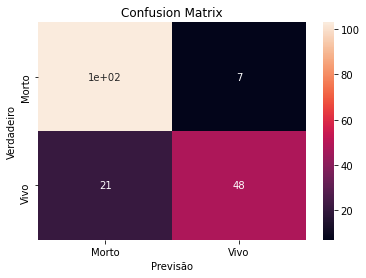

In [17]:
cm = confusion_matrix(y_test, previsao)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Previsão');
ax.set_ylabel('Verdadeiro'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Morto', 'Vivo']);
ax.yaxis.set_ticklabels(['Morto', 'Vivo']);

## Métricas

- A biblioteca **sklearn.metrics** tem a função **classification_report** que cria um relatório de texto mostrando as principais métricas de classificação. 
- **y_true** - Valores alvo verdadeiros (corretos). 
- **y_pred** - Alvos estimados conforme retornados por um classificador. 
- **labels** - Lista opcional de índices de rótulo a serem incluídos no relatório. 
- **target_names** - Nomes de exibição opcionais que correspondem aos rótulos (mesma ordem) 
- **sample_weight** - Peso das Amostras
- **digits** - Número de dígitos para formatar valores de ponto flutuante de saída. Quando output_dict for True, isso será ignorado e os valores retornados não serão arredondados.
- **output_dict** - Se verdadeiro, retorna a saída como dict
- **zero_division**: 'warn', 0 or 1, default='warn' - Define o valor a ser retornado quando houver uma divisão zero. Se definido como “aviso”, funciona como 0, mas os avisos também são gerados. 

In [18]:
print(classification_report(y_test, previsao, target_names = ['Morto', 'Vivo']))

              precision    recall  f1-score   support

       Morto       0.83      0.94      0.88       110
        Vivo       0.87      0.70      0.77        69

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179



## Acurácia

- A função **accuracy_score** pode ser usada para verificar a acurácia dos dados

In [19]:
accuracy_score(y_test, previsao)

0.8435754189944135

# Validação Cruzada

- A função **cross_val_score** realiza a validação cruzada.
- **estimator** - O objeto a ser usado para ajustar os dados (classificador).
- **X** - array-like of shape (n_samples, n_features) -   Os dados para caber. Pode ser, por exemplo, uma lista ou um array.
- **y** - array-like of shape (n_samples,) or (n_samples, n_outputs), default=None - A variável alvo a tentar prever no caso de aprendizagem supervisionada.
- **group** - array-like of shape (n_samples,), default = None -      Rótulos de grupo para as amostras usadas durante a divisão do conjunto de dados em conjunto de treinamento / teste. Usado apenas em conjunto com uma instância cv "Grupo" (por exemplo, GroupKFold).
- **scoring** - str ou callable, default = None - Um str (consulte a documentação de avaliação do modelo) ou um objeto / função que pode ser chamado de scorer com scorer de assinatura (estimador, X, y) que deve retornar apenas um único valor. Semelhante a cross_validate, mas apenas uma única métrica é permitida.  Se Nenhum, o marcador padrão do estimador (se disponível) é usado.
- **cv** - int, gerador de validação cruzada ou iterável, padrão = None -      Determina a estratégia de divisão de validação cruzada. As entradas possíveis para cv são:
    - Nenhum, para usar a validação cruzada de 5 vezes padrão,
    - int, para especificar o número de dobras em um KFold (estratificado),         - Divisor de CV,
    - Um rendimento iterável (treinar, testar) se divide como matrizes de índices.
    - Para entradas int / Nenhum, se o estimador for um classificador ey for binário ou multiclasse, StratifiedKFold é usado. Em todos os outros casos, o KFold é usado. Esses divisores são instanciados com shuffle = False para que as divisões sejam iguais nas chamadas.
    
- **n_jobs** - int, default = None - Número de trabalhos a serem executados em paralelo. O treinamento do estimador e o cálculo da pontuação são paralelizados nas divisões de validação cruzada. Nenhum significa 1, a menos que em um contexto joblib.parallel_backend. -1 significa usar todos os processadores. 
- **verbose** - int, default = 0 - O nível de verbosidade.
- **fit_params** - dict, default = None - Parâmetros para passar para o método de ajuste do estimador (classificador).
- **pre_dispatch** - int ou str, default = ’2 * n_jobs’ - Controla o número de trabalhos que são despachados durante a execução paralela. Reduzir esse número pode ser útil para evitar uma explosão de consumo de memória quando mais tarefas são despachadas do que as CPUs podem processar. Este parâmetro pode ser:
    - Nenhum, caso em que todos os empregos são imediatamente criados e reproduzidos. Use isso para trabalhos leves e de execução rápida, para evitar atrasos devido à geração sob demanda dos trabalhos
    - Um int, dando o número exato de empregos totais que são gerados
    -  Um str, dando uma expressão em função de n_jobs, como em ‘2 * n_jobs’
- **error_score** - raise ou numérico, default = np.nan -  Valor a ser atribuído à pontuação se ocorrer um erro no ajuste do estimador. Se definido como ‘aumentar’, o erro é gerado. Se um valor numérico for fornecido, FitFailedWarning é gerado 


In [20]:
x = df.drop(columns='Survived')
y = df['Survived']
scores = cross_val_score(classificador, x, y, cv = 5)

print("Acurracy: %0.2f (+\-) %0.2f " % (scores.mean(), scores.std() * 2))

Acurracy: 0.82 (+\-) 0.04 


# Podar a Árvore

- Devemos pergar o menor erro possível para poder a árvore 

In [21]:
classificador = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2)

#Rodar novamente
classificador = classificador.fit(x_train, y_train)

# CLASSIFICANDO
previsoes = classificador.predict(x_test)

# Accuracy
accuracy_score(y_test, previsoes)

0.8156424581005587

# Regressão

- Para fazer predições com regressão, use a função GradientBoostingRegressor

```Python
from sklearn.ensemble import GradientBoostingRegressor
```